<a href="https://colab.research.google.com/github/slachitoff/CS-GY-6613-Assignments/blob/main/CS_GY_6613_Final_TakeHome.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Forecasting Overview

Time series forecasting is a process of statistical analysis that uses past data trends to predict future values. In this specific instance, we are using the total monthly retail sales data taken from the Federal Reserve Bank of St. Louis as our historical dataset. 

This data is split into training and test sets before being fed into a Multilayer Perceptron model, which attempts to generalize the trends of the sales data, and generate predictions of monthly retail sales for future months beyond the scope of the original training set. 

Finally, these predictions are plotted alongside the actual sales data for the predicted months in order to visualize the behaviour of the MLP model in comparison to the actual values in the test set.

# Import Libraries

In [ ]:
#import numpy library
import numpy as np
#import pandas library
import pandas as pd
#import seaborn visualization library 
import seaborn as sns
#import rcParams object for matplotlib
from pylab import rcParams
#import matplotlib library
import matplotlib.pyplot as plt
#import the resource configuration module form matplotlib
from matplotlib import rc
#import the Sequential class from Keras
from tensorflow.keras.models import Sequential
#import the Long Short-Term Memory model class from Keras
from tensorflow.keras.layers import LSTM
#import Dense layer class from Keras
from tensorflow.keras.layers import Dense
#import Adam optimizer from Keras
from tensorflow.keras.optimizers import Adam
#Allow matplotlib plots to be displayed directly in the notebook
%matplotlib inline
#Set a high-resolution display for figures in the notebook
%config InlineBackend.figure_format='retina'
#Set the style and palette for seaborn plots
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
#Set default matplotlib plot dimensions
rcParams['figure.figsize'] = 16, 10

# Upload data

In [ ]:
# Original Data Source: https://fred.stlouisfed.org/series/RSXFSN
#Import data from local device
from google.colab import files
uploaded = files.upload()

Saving RSXFSN.csv to RSXFSN.csv


In [ ]:
# Store data in pandas DataFrame
df = pd.read_csv("RSXFSN.csv")

In [ ]:
# keep only relevant real GDP only
keep_columns = ['RSXFSN']
df = df[keep_columns]
# rescale retail sales data to be a fraction
df = df/10000

# Preprocess Data

In [ ]:
#use 80% of starting set as training set
n_train = int(len(df) * 0.8)
#use remaining 20% as the test set
n_test = len(df) - n_train
#split data based on previously established parameters
train, test = df.iloc[0:n_train], df.iloc[n_train:len(df)]
print(len(train), len(test))

300 75


In [ ]:
#create a function to generate timeseries data
def get_timeseries(x, n_steps=1):
    #create lists for input and output sequences
    x_ts, y_ts = [], []
    #loop through the elements of x
    for ii in range(len(x) - n_steps):
        #store n_steps rows from x as a numpy array v
        v = x.iloc[ii:(ii + n_steps)].values
        #append v to list x_ts
        x_ts.append(v)
        #store n_steps rows from x as a numpy array q
        w = x.iloc[ii + n_steps].values
        #append array q to list y_ts
        y_ts.append(w)
    return np.array(x_ts), np.array(y_ts)

In [ ]:
#define the number of time steps for the LSTM
n_steps = 16
#define the number of features input to the LSTM
n_features = 1
# convert training data to a time series dimension: [samples, n_steps, n_features]
x_train, y_train = get_timeseries(train, n_steps)
# convert test data to a time series dimension: [samples, n_steps, n_features]
x_test, y_test = get_timeseries(test,n_steps)

print(x_train.shape, y_train.shape)


(284, 16, 1) (284, 1)


# MLP Model

In [ ]:
# define model
#create an instance of a sequential model, which is a series of in-order layers
model = Sequential()
#create a layer of 50 neurons, and a Rectified Linear Unit activation function, which takes "n_step" as its input (16, in this case)
model.add(Dense(50, activation='relu', input_dim=n_steps))
#create another dense layer with one neuronas the output
model.add(Dense(1))
#configures the model to use a MSE loss function, and an Adam optimizer with a learning rate of 0.001
model.compile(loss='mean_squared_error', optimizer=Adam(0.001))

# MLP Training

In [ ]:
#fit the compiled model to the training data
#takes x_train as input, and y_train as output. Iterates through the entire training set 500 times, using 32 samples to update the weights each time.
#Uses 10% of the training data to evaluate the performance of the model during training. Verbose=1 outputs a progress bar to show training progress. No shuffling of training data each epoch.
history = model.fit(x_train, y_train,epochs=500,batch_size=32,validation_split=0.1,verbose=1,shuffle=False)

Epoch 1/500
8/8 [==============================] - 0s 12ms/step - loss: 0.6652 - val_loss: 0.5625
Epoch 2/500
8/8 [==============================] - 0s 8ms/step - loss: 0.6660 - val_loss: 0.5631
Epoch 3/500
8/8 [==============================] - 0s 7ms/step - loss: 0.6663 - val_loss: 0.5619
Epoch 4/500
8/8 [==============================] - 0s 7ms/step - loss: 0.6663 - val_loss: 0.5619
Epoch 5/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6666 - val_loss: 0.5625
Epoch 6/500
8/8 [==============================] - 0s 7ms/step - loss: 0.6664 - val_loss: 0.5611
Epoch 7/500
8/8 [==============================] - 0s 7ms/step - loss: 0.6659 - val_loss: 0.5610
Epoch 8/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6659 - val_loss: 0.5614
Epoch 9/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6653 - val_loss: 0.5597
Epoch 10/500
8/8 [==============================] - 0s 8ms/step - loss: 0.6650 - val_loss: 0.5594
Epoch 11/500
8/8 [==========

#CNN Modeling

In [ ]:
#MaxPooling1D, Conv1D, Flatten are imported from Keras
from tensorflow.keras.layers import Conv1D, Flatten
#Create another instance of a sequential model
modelCNN = Sequential()
#Add a 1D Convolutional layer consisting of 68 filters, each with a kernal size of 3.
#ReLu is again used as the activator, and the input shape is (n_steps, 1), where n_steps is the number of time steps in the 
#series data, and 1 is the number of features of the input.
modelCNN.add(Conv1D(filters=68, kernel_size=3, activation="relu",input_shape=(n_steps, 1)))
#The output of the convolutional network is a 3D tensor of shape (None, 14, 68).
#Flatten() is used to convert this output to a 2d tensor of shape (None, 952) which can be input into the Dense layer.
modelCNN.add(Flatten())
#The Dense layer with a single neuron gets a 2D tensor as its input and outputs a single predicted value. 
modelCNN.add(Dense(1))
#As with the MLP version, the model is compiled, a MSE loss function is utilized, as well as an Adam optimizer with the same learning rate of 0.001.
modelCNN.compile(loss='mean_squared_error', optimizer=Adam(0.001))

#Notes on CNN Parameters

Most of the process of selecting parameters was trial and error. 

Originally, I had also implemented a Max Pooling Layer after the convolution layer, but I found that for any pool size greater than one, the model's loss increased. In hindsight, this seems obvious, as the Max Pooling Layer only seemed to be reducing the size of "n_steps", essentially giving the network less temporal data to consider.

The original MLP model used a dense layer of 50 neurons to determine the number of model parameters. On the other hand, the CNN uses a convolutional layer with 68 filter to produce 68 feature maps. Again, this number was reached simply through trial and error. Initially, I started with 50 filters, to match the MLP neuron count. I tried reducing the filters, but found poor results. Likewise, I tried increasing the filters above 70, and also found that to maybe be too many. Of all the options I tried, 68 just seemed to work the best, based on the resulting training and validation losses.

Kernel size was relatively easy to choose. I began with a kernal size of 1, and attempted training increasing the kernel size by one each time, up to 5. A kernal size of 3 seemed optimal. 

I started with a ReLu activation function, as it was the same function used in the MLP model, and I didn't try anything else. I'm not very familiar with other activation functions that would be obvious choices for this scenario.

I also chose to compile the model using the same parameters used in the MLP version. I didn't try different loss functions or optimizers, but I experimented with other learning rates, but found the most success with the initial value of 0.001.

Like with many of the other parameters, I used those from the MLP model for training as well. I initially began with 500 epochs and a batch size of 32. I steadily increased the number of epochs, and did not observe the plateauing or fluctuation of validation loss that I would typically associate with overfitting until epochs above about 900, so that seemed like a safe number. Of course, this means the model takes longer to train, but because the model is relatvely simple, training time is not very long anyway, and a model which produces lower loss values is the ultimate goal. 

Although I did experiment with a variety of batch sizes as well, I cannot say definitively what size produced the best results. What I will say is that batch sizes below about 30, or above 50 appeared to be suboptimal. Ultimately, I went with 48, but it's a somewhat arbitrary decision. I briefly experimented a bit with the validation split, but felt that 10% seemed like a good option.

# CNN Training

In [ ]:
historyCNN = modelCNN.fit(x_train, y_train,epochs=900,batch_size=48,validation_split=0.1,verbose=1,shuffle=False)

Epoch 1/900
6/6 [==============================] - 1s 46ms/step - loss: 641.7453 - val_loss: 673.6859
Epoch 2/900
6/6 [==============================] - 0s 14ms/step - loss: 172.7807 - val_loss: 88.8433
Epoch 3/900
6/6 [==============================] - 0s 10ms/step - loss: 13.2315 - val_loss: 31.5060
Epoch 4/900
6/6 [==============================] - 0s 14ms/step - loss: 38.2434 - val_loss: 91.7741
Epoch 5/900
6/6 [==============================] - 0s 11ms/step - loss: 35.9336 - val_loss: 37.3285
Epoch 6/900
6/6 [==============================] - 0s 15ms/step - loss: 9.4298 - val_loss: 9.1646
Epoch 7/900
6/6 [==============================] - 0s 11ms/step - loss: 6.6881 - val_loss: 16.7086
Epoch 8/900
6/6 [==============================] - 0s 14ms/step - loss: 9.5647 - val_loss: 15.6167
Epoch 9/900
6/6 [==============================] - 0s 10ms/step - loss: 6.9334 - val_loss: 9.6032
Epoch 10/900
6/6 [==============================] - 0s 11ms/step - loss: 5.3015 - val_loss: 9.7533
Epoc

# Evaluation

In [ ]:
#use the model to make predictions based on a new dataset (test data)
y_pred = model.predict(x_test)
#use the model to make predictions based on a new dataset (test data)
y_predCNN = modelCNN.predict(x_test)

2/2 [==============================] - 0s 10ms/step


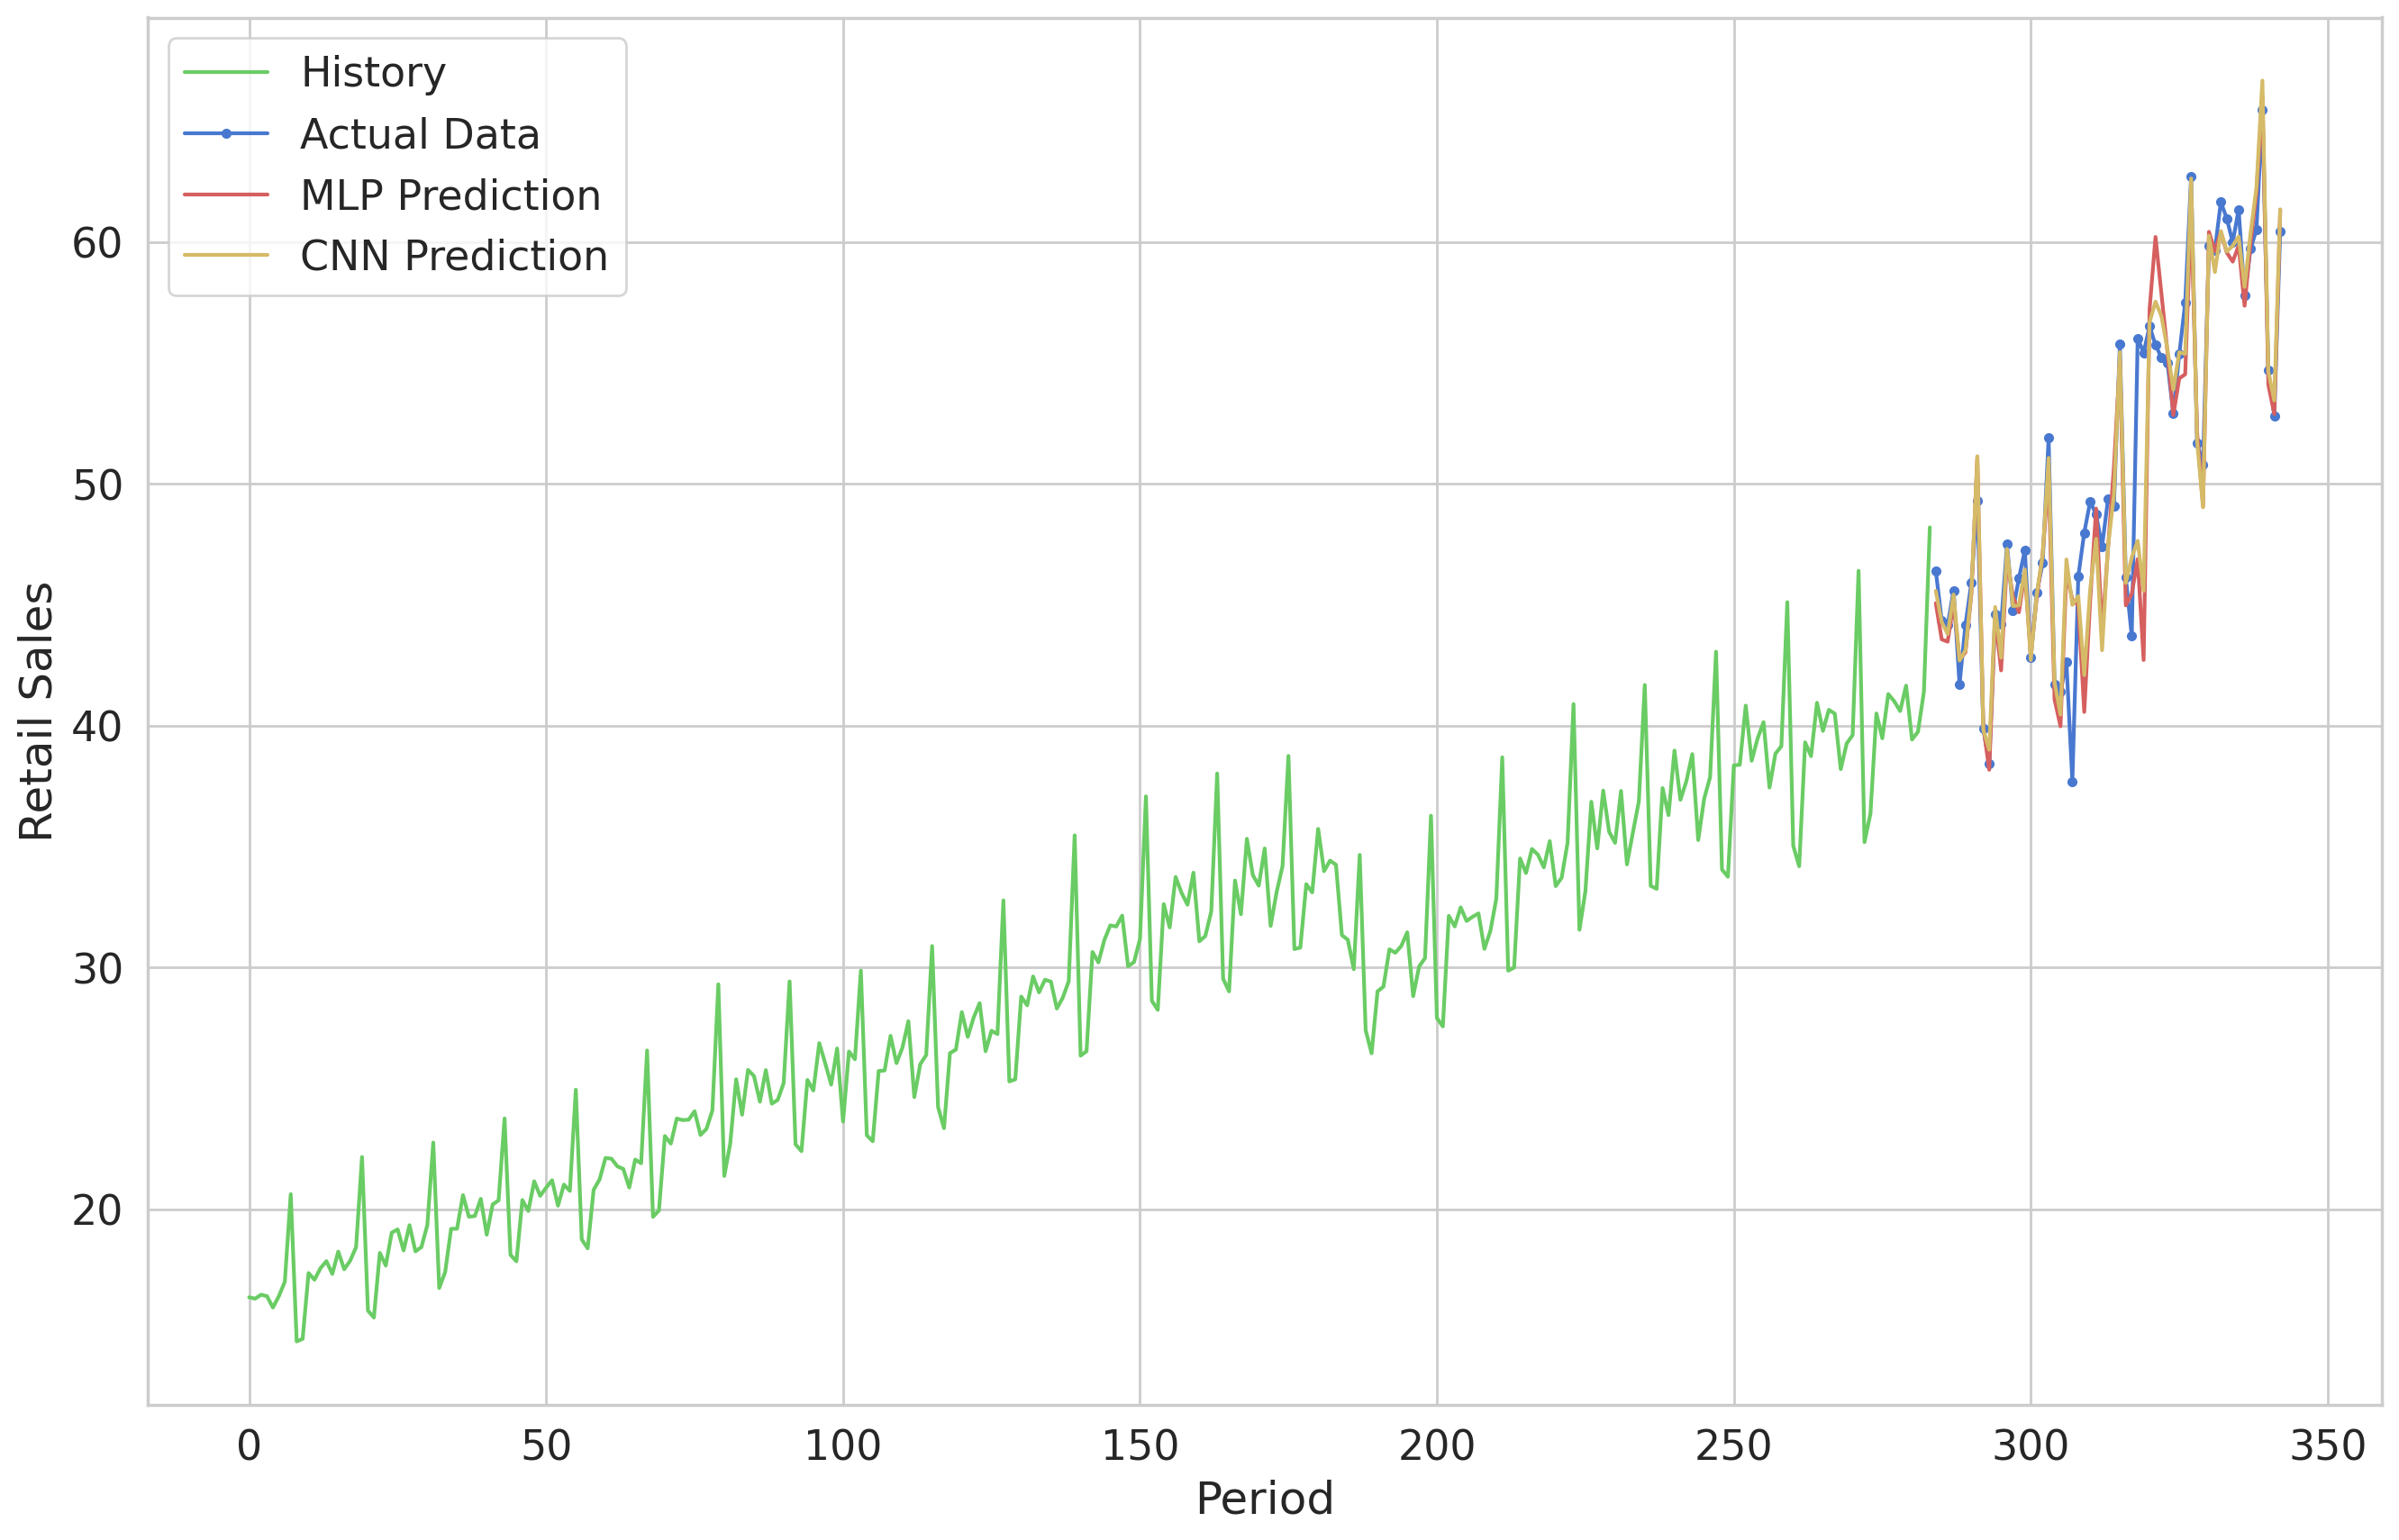

In [ ]:
#plot the historical training data
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="History")
#plot the test data
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="Actual Data")
#plot the predicted data generated by the MLP model
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="MLP Prediction")
#plot the predicted data generated by the CNN model
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_predCNN, 'y', label="CNN Prediction")
#label x and y-axes
plt.ylabel('Retail Sales')
plt.xlabel('Period')
#create a legend
plt.legend()
#display the plot
plt.show();

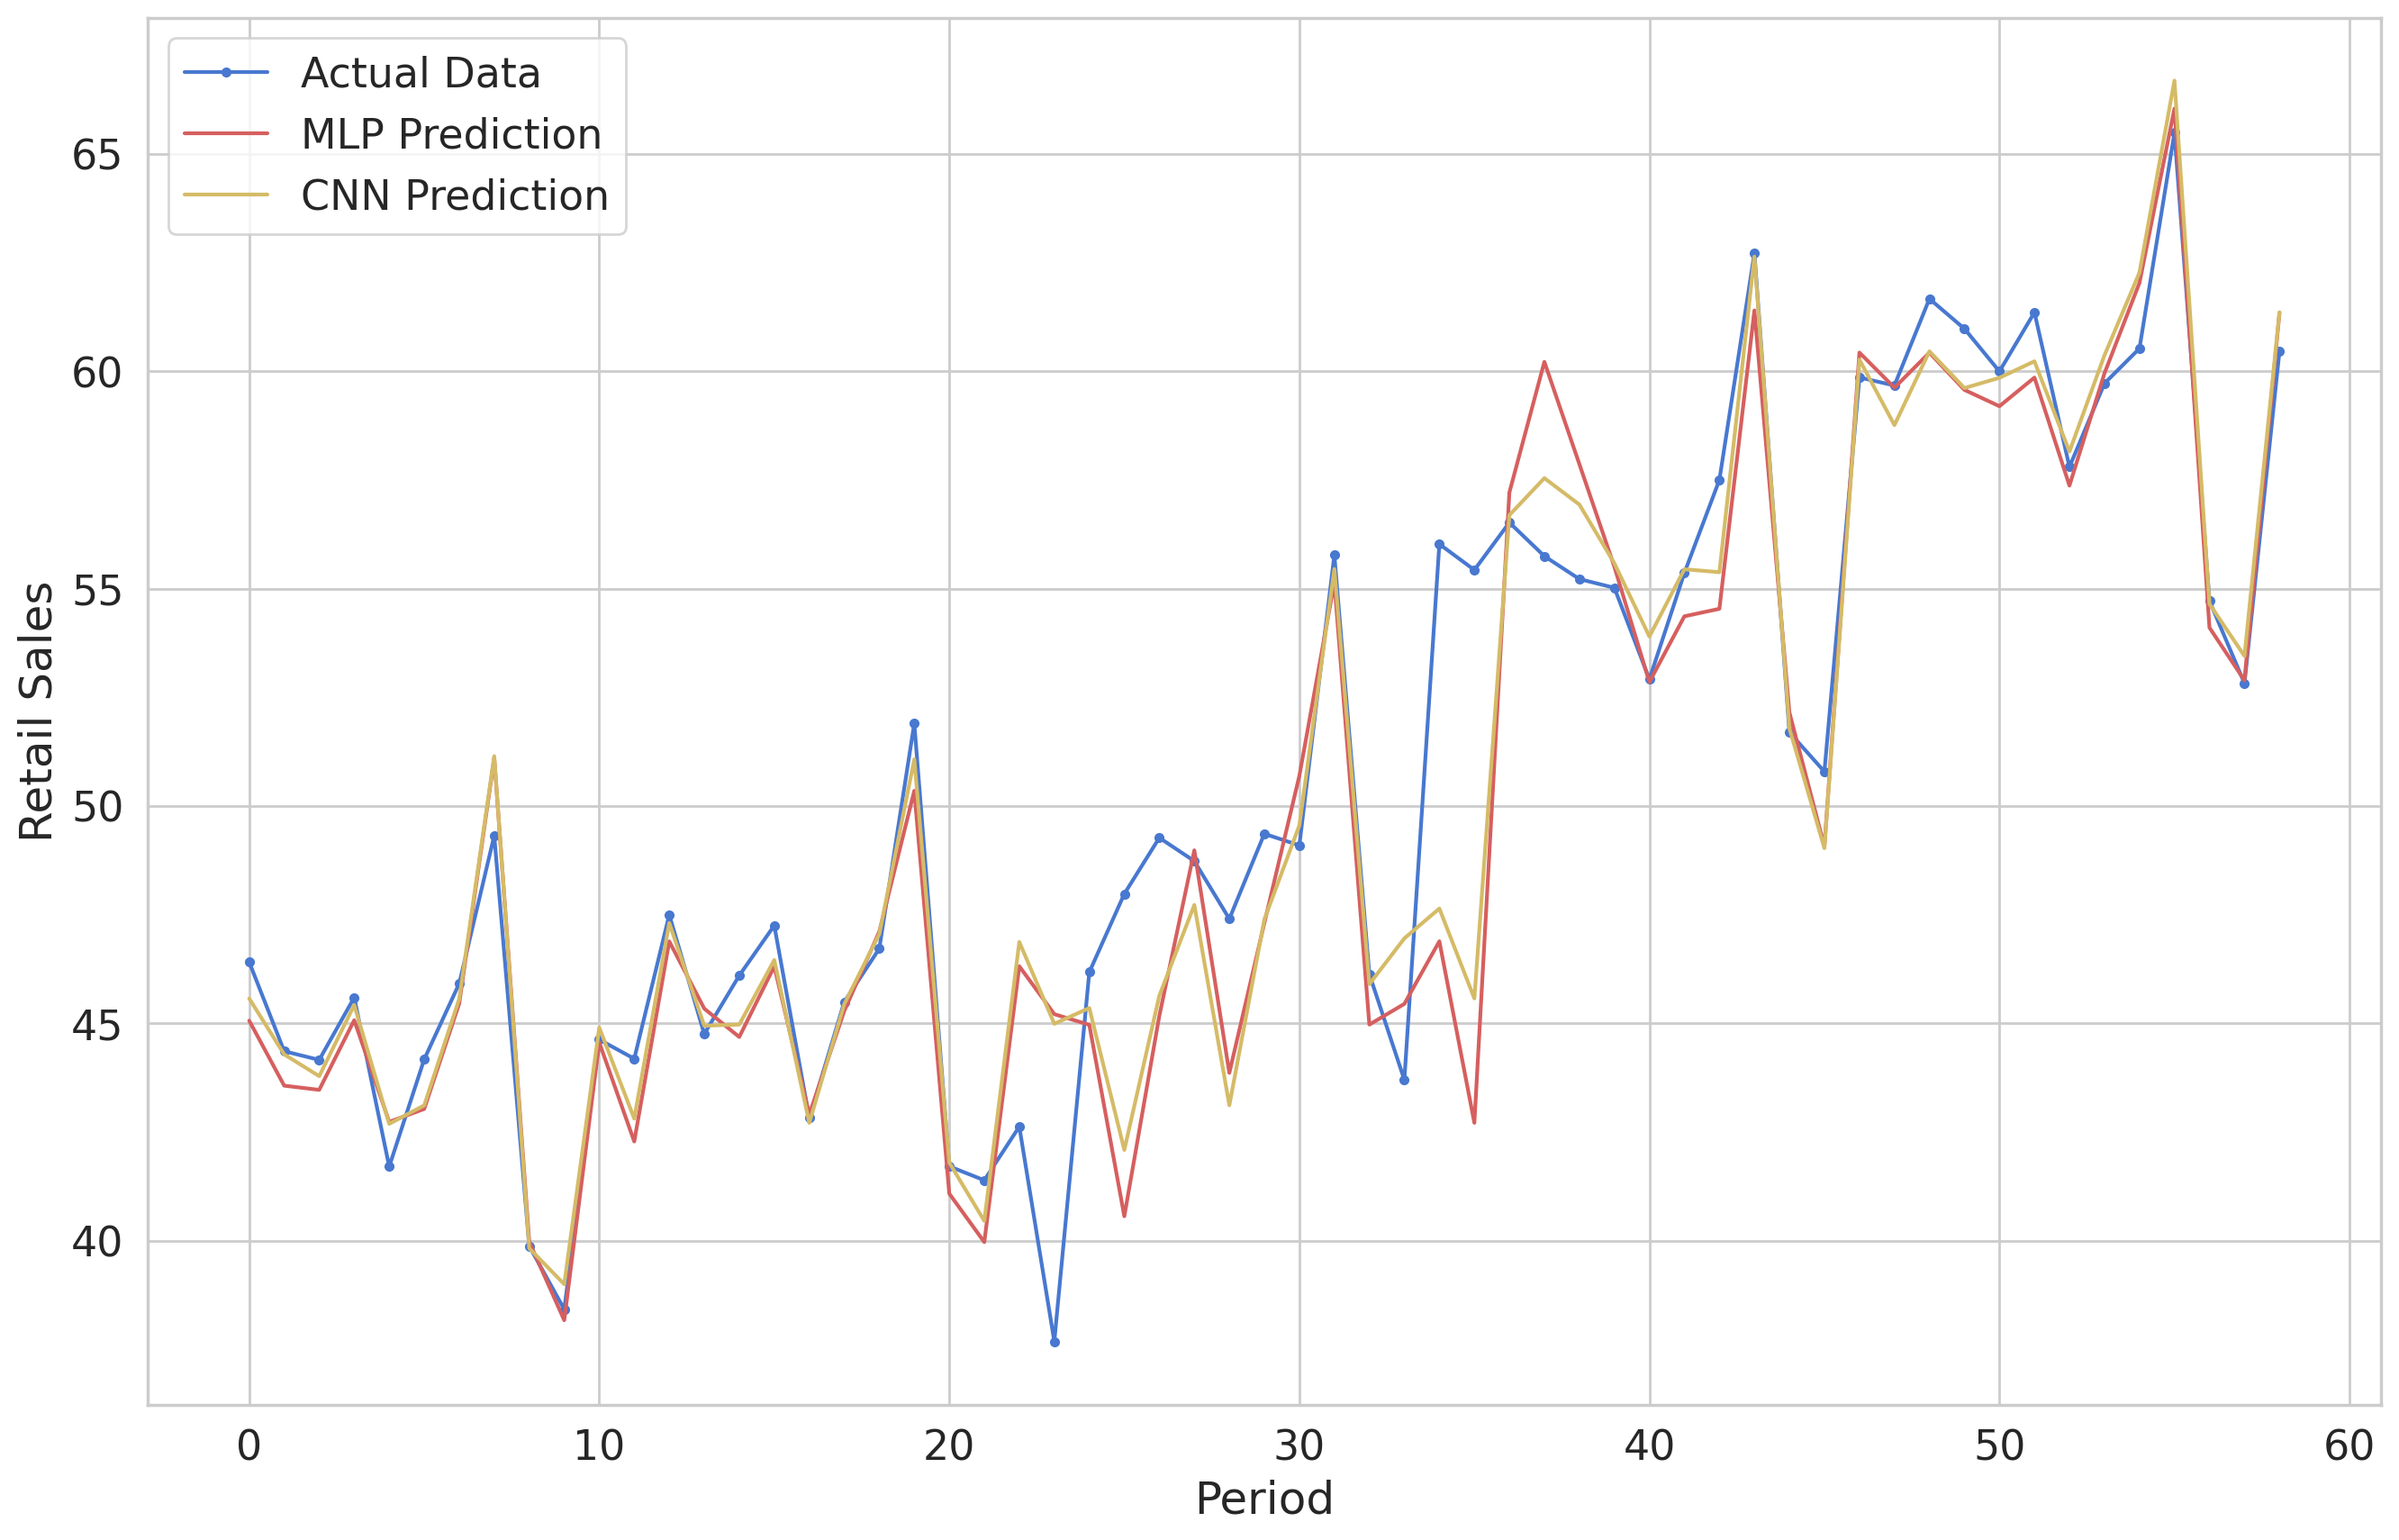

In [ ]:
#plot the test data
plt.plot(y_test, marker='.', label="Actual Data")
#plot the predicted data generated by the model
plt.plot(y_pred, 'r', label="MLP Prediction")
#plot the predicted data generated by the model
plt.plot(y_predCNN, 'y', label="CNN Prediction")
#label the x and y-axes
plt.ylabel('Retail Sales')
plt.xlabel('Period')
#create a legend
plt.legend()
#display the plot
plt.show();

# Model Comparison

I did my best to achieve as accurate a CNN model as possible, and in comparison to the MLP model, the CNN model seems to perform slightly better, both in terms of training loss and validation loss. Overall, looking at the plots comparing the predictions of the two models with the real sales data, we can see that on average, the CNN tend to predict values slightly closer to that of the actual dataset. Even so, the different in outcomes between these two models seems pretty marginal, with a final difference in training and validation loss both of about 0.15. In fact, the the predictions generated by the models actually align very closely, which leads me to believe that the model outputs are fairly accurate inferences based on the provided dataset. Given the data, producing predictions that align more closely with the actual data might not be possible.

One very obvious reason why the CNN model produced slightly more accurate predictions has nothing to do with the actual architecture of the model. 500 training epochs may not have been the optimal number for either the CNN or the MLP model, and had the MLP run for an addition 400 epochs, it might very well have outperformed the CNN model which was allowed to train for 900 epochs.

Apart from that, the CNN has a greater number of filters than the MLP has neurons. This potentially allows the CNN to take into account a greater number of relevant features in the data.

One aspect of CNNs that was not taken advantage of in this model is that of pooling layers. While in other scenarios, this might prevent the model from becoming overly complex and overfitting, I did not find this to be a substantial concern in this case.

CNN filters are most often used in image-processing tasks which must account for spatial relationships between filters. In my mind, it seems possible that these filters might also be able to capture temporal relationship, as is te goal with time series prediction. There seems to be fairly clear, if difficult to precisely predict, patterns in the total retail sales overt time. If a filter is able to classify these patterns as it would image features such as edges or curves, that could possibly contribute to the model's success.